# Demo of Scrambling with Operators using the library in operator_3q_lib.py

For convenience we made a ready to use scrambling operator library module, containing the opertors we found in the referenced "Quantum Scrambling Library".

Reference: [Building and Programming a Universal Ion Trap Quantum Computer](http://iontrap.umd.edu/wp-content/uploads/2013/10/FiggattThesis.pdf)

### Let's see how we can plug operators like such into our scrambling verification protocol and see how the fidelity turns out for each!

In [1]:
# first some general imports:
%matplotlib inline
import matplotlib, qiskit, pprint, itertools
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, transpile, schedule, assemble
from qiskit.circuit import *
from qiskit.circuit.library.standard_gates import *
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeAlmaden, FakeMelbourne
from qiskit.visualization import *
from qiskit.circuit.library import *

In [2]:
# import our utils for Quantum Information Scrambling Verification Test:
from QSVT_utils import *

# import our library with 3 qubit operators
from operator_3q_lib import *

In [3]:
# load IBM Q account:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# get simulator:
qasm_simulator = Aer.get_backend('qasm_simulator') 

## Experiment A: $Ucz$

In our first test, we are going to take a look at this one:

![U_cz](./pics/U_cz_matrix.png)

Reference: [Building and Programming a Universal Ion Trap Quantum Computer](http://iontrap.umd.edu/wp-content/uploads/2013/10/FiggattThesis.pdf), Chapter 5.9.4: Scrambling Unitary Ucz


Just as we did in our previous demo notebook [Demo_1_ScramblingVerificationTest_Gateset](Demo_1_ScramblingVerificationTest_Gateset.ipynb), we'll again define our experimental variables first (keep in mind, that the size of the operators must match the number of qubits $n$ the scrambler get applied to, in this case three). This time, we only need a list containing the operators we want to use in the scrambler instead of the two list with one-qubit and two-qubit gates in the previous demo notebook.

In [4]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 1 # number of repetitions of the unitary

n = 3 # size of the scrambling unitary / operator

operatorlist = [Ucz_op] # list storing the operators we want to use in our scrambler

You are save to assume, that you are free to combine gate sets and operators just as you like it in your own version of this experimental setup (as long as you don't forget to pass or instruct them to pich a matching number of qubits in case you want to wild with your combinations).

For our experiment right now we are done with setup variables, and can just go ahead by simply running the following cell without any adjustments to get all the lists and variables we need (again just like we did before in the previous demo notebook [Demo_1_ScramblingVerificationTest_Gateset](Demo_1_ScramblingVerificationTest_Gateset.ipynb):

In [5]:
#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

Now we are done defining stuff again and can just run the next cell to get our full experimental circuit.

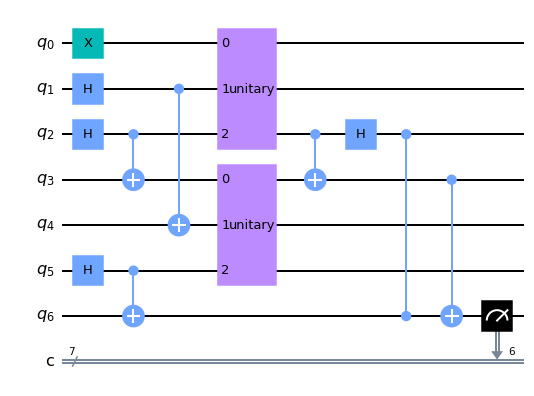

In [6]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply the scrambling:
rnum = 0
while rnum < reps:
    apply_operators(circ, operatorlist)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
circ.draw('mpl', plot_barriers=False)

Here we go! let's run it on the simulator!


 Fidelity Bob Qubit:   	 100.0%


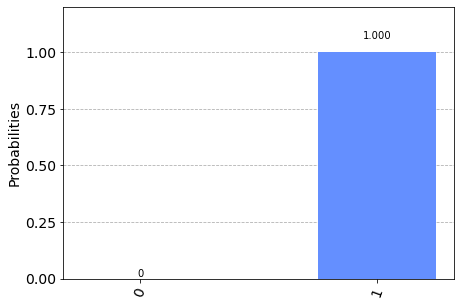

In [7]:
###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

#### Let's quickly do one more run of this experiment, but this time with two applications of the operator:


 Fidelity Bob Qubit:   	 46.1%


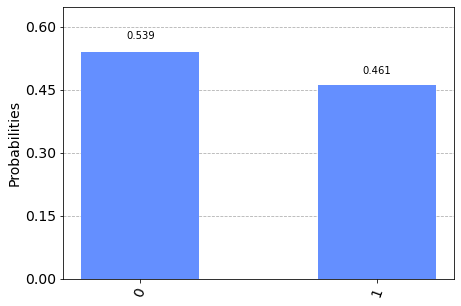

In [8]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 2 # number of repetitions of the unitary

n = 3 # size of the scrambling unitary / operator

operatorlist = [Ucz_op] # list storing the operators we want to use in our scrambler

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply the scrambling:
rnum = 0
while rnum < reps:
    apply_operators(circ, operatorlist)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

Hmm, doesn't this look a lot like what we found in our experiments 1A and 1C [here](Demo_1_ScramblingVerificationTest_Gateset.ipynb)? This may or may not be in interesting lead to follow, anyhow, we are going to stick to the topic of this demo right now! So let's take a look at one more operator:

# Experiment B: $Us$ 

This is the operator, we'll use in the scrambler this time:

![U_s](./pics/U_s_matrix.jpg)


Reference: [Building and Programming a Universal Ion Trap Quantum Computer](http://iontrap.umd.edu/wp-content/uploads/2013/10/FiggattThesis.pdf), Chapter 5.9.3: Scrambling Unitary Us


The general experimental setup won't change much, we'll put this operator into our operator list instead of the last one. 
Then we can directly run the experiment to get get the scrambling propertiy in terms of teleportation fidelity.


 Fidelity Bob Qubit:   	 49.8%


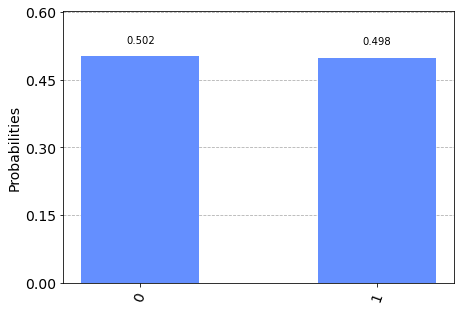

In [9]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 1 # number of repetitions of the unitary

n = 3 # size of the scrambling unitary / operator

operatorlist = [Us_op] # list storing the operators we want to use in our scrambler

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply the scrambling:
rnum = 0
while rnum < reps:
    apply_operators(circ, operatorlist)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

In [10]:
Us_op

Operator([[-0.5+0.j,  0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j, -0.5+0.j,
           -0.5+0.j,  0. +0.j],
          [ 0. +0.j,  0.5+0.j, -0.5+0.j,  0. +0.j, -0.5+0.j,  0. +0.j,
            0. +0.j,  0.5+0.j],
          [ 0. +0.j, -0.5+0.j,  0.5+0.j,  0. +0.j, -0.5+0.j,  0. +0.j,
            0. +0.j,  0.5+0.j],
          [ 0.5+0.j,  0. +0.j,  0. +0.j,  0.5+0.j,  0. +0.j, -0.5+0.j,
           -0.5+0.j,  0. +0.j],
          [ 0. +0.j, -0.5+0.j, -0.5+0.j,  0. +0.j,  0.5+0.j,  0. +0.j,
            0. +0.j,  0.5+0.j],
          [ 0.5+0.j,  0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j,  0.5+0.j,
           -0.5+0.j,  0. +0.j],
          [ 0.5+0.j,  0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j, -0.5+0.j,
            0.5+0.j,  0. +0.j],
          [ 0. +0.j, -0.5+0.j, -0.5+0.j,  0. +0.j, -0.5+0.j,  0. +0.j,
            0. +0.j, -0.5+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))

# Random Operators

In [16]:
reps = 3 # let's generate a list of three random operators

n = 3 # number of qubits our scrambling operators span, as usual

operatorlist = [Operator(np.random.rand(2 ** n, 2 ** n)) for x in range(reps)] # our list with random operators


In [17]:
#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

In [18]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply the scrambling:
rnum = 0
while rnum < reps:
    apply_operators(circ, operatorlist)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

ExtensionError: 'Input matrix is not unitary.'